In [83]:
# --- Imports ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns

In [84]:
# --- Custom Transformer to Handle Empty Strings ---
class EmptyStringToNaN(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.replace('', np.nan)

In [85]:
# Load dataset
data = pd.read_csv('accepted_final.csv')  # Use the correct file path here
data = data.dropna(axis=1, how='all')
data.head()

,id,issue_d,loan_amnt,term,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,delinquent
0,112575999.0,7/1/2017,35000.0,60 months,851.51,9 years,RENT,175000.0,Verified,Charged Off,other,CA,13.51,0.0,710.0,714.0,0.0,1
1,122347826.0,11/1/2017,12100.0,36 months,467.83,4 years,MORTGAGE,106000.0,Not Verified,Fully Paid,debt_consolidation,VA,27.47,0.0,670.0,674.0,0.0,0
2,133439083.0,6/1/2018,17000.0,36 months,533.35,4 years,MORTGAGE,65000.0,Source Verified,Current,credit_card,CA,12.78,0.0,700.0,704.0,1.0,0
3,119216681.0,10/1/2017,12000.0,60 months,327.69,10+ years,RENT,60000.0,Verified,Current,debt_consolidation,AZ,26.60,0.0,660.0,664.0,2.0,0
4,142845437.0,10/1/2018,14000.0,36 months,426.61,4 years,MORTGAGE,57000.0,Source Verified,Current,debt_consolidation,CA,10.74,0.0,685.0,689.0,0.0,0


In [86]:
print("Missing values in each column:")
print(data.isnull().sum())

Missing values in each column:
id                         1
issue_d                    1
loan_amnt                  1
term                       1
installment                1
emp_length             22115
home_ownership             1
annual_inc                 1
verification_status        1
loan_status                1
purpose                    1
addr_state                 1
dti                      502
delinq_2yrs                1
fico_range_low             1
fico_range_high            1
inq_last_6mths             1
delinquent                 0
dtype: int64


In [87]:
#Data Encoding for loan_status
binary_mapping = {
    'Fully Paid': 0,
    'Current': 0,
    'In Grace Period': 0,
    'Late (16-30 days)': 1,
    'Late (31-120 days)': 1,
    'Charged Off': 1,
    'Default': 1
}

# Apply encoding
data["loan_status"] = data["loan_status"].map(binary_mapping)

In [88]:
# Check the column names to find the target column
print(data.columns)

Index(['id', 'issue_d', 'loan_amnt', 'term', 'installment', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'loan_status',
       'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'fico_range_low',
       'fico_range_high', 'inq_last_6mths', 'delinquent'],
      dtype='object')


In [89]:
# Check Class balnce in target
print("\nTarget class distribution")
print(data['loan_status'].value_counts(normalize=True))


Target class distribution
loan_status
0.0    0.928598
1.0    0.071402
Name: proportion, dtype: float64


In [90]:
print("\nUnique values in target column:")
print(data['loan_status'].unique())


Unique values in target column:
[ 1.  0. nan]


In [91]:
# Separate features (X) and target (y)
X = data.drop(columns=['loan_status'])  # Drop the target column 'loan_status'
y = data['loan_status']  # The target column is 'loan_status'

# --- Drop rows with missing values in either X or y ---
combined = pd.concat([X, y], axis=1)
combined = combined.dropna()
X = combined.drop(columns=['loan_status'])
y = combined['loan_status']

# Check the first few rows of X and y to confirm
print(X.head())
print(y.head())

            id    issue_d  loan_amnt        term  installment emp_length  \
0  112575999.0   7/1/2017    35000.0   60 months       851.51    9 years   
1  122347826.0  11/1/2017    12100.0   36 months       467.83    4 years   
2  133439083.0   6/1/2018    17000.0   36 months       533.35    4 years   
3  119216681.0  10/1/2017    12000.0   60 months       327.69  10+ years   
4  142845437.0  10/1/2018    14000.0   36 months       426.61    4 years   

  home_ownership  annual_inc verification_status             purpose  \
0           RENT    175000.0            Verified               other   
1       MORTGAGE    106000.0        Not Verified  debt_consolidation   
2       MORTGAGE     65000.0     Source Verified         credit_card   
3           RENT     60000.0            Verified  debt_consolidation   
4       MORTGAGE     57000.0     Source Verified  debt_consolidation   

  addr_state    dti  delinq_2yrs  fico_range_low  fico_range_high  \
0         CA  13.51          0.0         

In [92]:
# Identify categorical and numeric columns
categorical_cols = list(X.select_dtypes(include=['object']).columns)
numeric_cols = list(X.select_dtypes(exclude=['object']).columns)

In [93]:
# Create preprocessing pipeline for numeric and categorical columns
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values by replacing with mean
    ('scaler', StandardScaler())  # Normalize numeric features
])

categorical_pipeline = Pipeline(steps=[
    ('empty_to_nan', EmptyStringToNaN()),
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing values by replacing with the most frequent value
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  # Encode categorical features using one-hot encoding
])

In [94]:
# Combine both pipelines into a single ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_cols),
        ('cat', categorical_pipeline, categorical_cols)
    ])

In [95]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [96]:
# Apply preprocessing pipeline to training and testing data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [97]:
# --- Convert to dense arrays safely ---
if hasattr(X_train_preprocessed, "toarray"):
    X_train_dense = X_train_preprocessed.toarray()
else:
    X_train_dense = X_train_preprocessed

if hasattr(X_test_preprocessed, "toarray"):
    X_test_dense = X_test_preprocessed.toarray()
else:
    X_test_dense = X_test_preprocessed

In [98]:
# Optionally, if you want to check the shapes of the transformed data
print(f"Shape of preprocessed training data: {X_train_preprocessed.shape}")
print(f"Shape of preprocessed testing data: {X_test_preprocessed.shape}")

Shape of preprocessed training data: (181646, 117)
Shape of preprocessed testing data: (77849, 117)


In [99]:
# --- Final NaN Check ---
print("\nChecking for NaNs before training:")
print("X_train_dense has NaNs:", np.isnan(X_train_dense).any())
print("X_test_dense has NaNs:", np.isnan(X_test_dense).any())
print("y_train has NaNs:", pd.isnull(y_train).any())
print("y_test has NaNs:", pd.isnull(y_test).any())


Checking for NaNs before training:
X_train_dense has NaNs: False
X_test_dense has NaNs: False
y_train has NaNs: False
y_test has NaNs: False


#  Train the Model 

In [100]:
model = LogisticRegression(max_iter=1000)
fit_model = model.fit(X_train_dense, y_train)
print("✅ Model trained successfully.")

✅ Model trained successfully.


In [101]:
y_pred = model.predict(X_test_dense)

Accuracy: 100.00%
Confusion Matrix:
[[72432     0]
 [    0  5417]]
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     72432
         1.0       1.00      1.00      1.00      5417

    accuracy                           1.00     77849
   macro avg       1.00      1.00      1.00     77849
weighted avg       1.00      1.00      1.00     77849



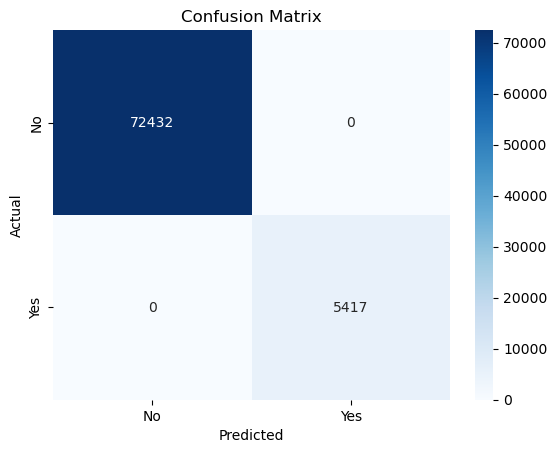

In [102]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Classification Report (Precision, Recall, F1-score)
class_report = classification_report(y_test, y_pred)
print('Classification Report:')
print(class_report)

# ROC-AUC Score
#X_test = X_test.drop(columns = ["issue_d"])
#X_test = X_test.drop(columns = ["term"])
#roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
#print(f'ROC-AUC Score: {roc_auc:.2f}')

# Visualize Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()